# ARGO Example

This notebook contains an example of how the ARGO package can be used to:

* Generate new rules
* Optimise existing rules
* Combine these rules and remove those which are unnecessary
* Generate rule score
* Test final rule set and scores on test data
* Generate/update the system-ready configs of the final rule set
* Update the Simility environment with the final rule set

## Requirements

To run, you'll need the following:

* Install the ARGO package - see the readme for more information.
* A raw, labelled dataset.

---

## Table of contents

1. [Read/process data](#ReadProcessData)
2. [Rule generation](#RuleGeneration)
3. [Rule Optimisation](#RuleOptimisation)
4. [Combine rules and remove those which are unnecessary](#CombineRules)
5. [Score rules](#ScoreRules)
6. [Remove filtered rules from rule set](#RemoveFiltered)
7. [Test final rule set and scores on test data](#TestFinal)
8. [Convert generated rule conditions to system-ready](#ConvertGenToSys)
9. [Generate/update the system-ready configs of the rules](#GenUpdateSysConfigs)
10. [Update the Simility environment with the final rule set](#UpdateSimility)	

----

## Import packages

In [1]:
from simility_apis.set_password import set_password
from argo.read_data import DataReader
from argo.simility_requests import ReturnCassandraDatatypes, ReturnPipelineOutputDatatypes, ReturnCassandraPipelineOutputMapping, \
    ReturnRuleConditionsFromSimility, ReturnRuleConfigsFromSimility, CreateRulesInSimility, UpdateRulesInSimility
from argo.rule_generation import RuleGeneratorDT, RuleGeneratorOpt
from argo.rule_optimisation import RuleOptimiser, FScore, Precision
from argo.rules import Rules, ConvertProcessedConditionsToGeneral, ReturnMappings
from argo.correlation_reduction import AgglomerativeClusteringFeatureReduction, JaccardSimilarity
from argo.rule_filtering import FilterRules, GreedyFilter, FilterCorrelatedRules
from argo.rule_scoring import LogRegScorer, PerformanceScorer, ConstantScaler, MinMaxScaler, RuleScorer
from argo.system_config_generation import CreateNewConfigs, UpdateExistingConfigs
from argo.rule_application import ArgoRuleApplier, SimRuleApplier

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from category_encoders.one_hot import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

---

## Read/process data <a name="ReadProcessData"></a>

### Read in data

Note: If using the in-built APIs in ARGO to generate or update rules in the system, it's important that the datatypes used in the data align to the Cassandra datatypes in the system. For this, use the *read_data* module (not that if this isn't required, you can use Panda's standard reading methods).

First, you need to set the password you use to log in to the Simility environment:

In [3]:
set_password()

Please provide your password for logging into the Simility platform:  ·········


Now let's define some credential-related variables (as these are used in multiple classes throughout the example):

In [4]:
url = 'http://sim-ds.us-central1.gcp.dev.paypalinc.com'
app_prefix = 'james_testing'
user = 'james@simility.com'
base_entity = 'transaction'

Now we can use the *DataReader* class from the *read_data* module to read in the raw, labelled dummy pipeline output data (stored as a CSV file). **Note that the CSV should not contain duplicate records**:

In [5]:
dr = DataReader(url=url,
                app_prefix=app_prefix,
                user=user,
                base_entity=base_entity)

In [6]:
data = dr.read_csv(filepath='dummy_data/dummy_pipeline_output_data.csv',
                   index_col='eid')

In [7]:
data.shape

(13276, 64)

Then we can split the data into features (*X*) and the target column (*y*):

In [8]:
fraud_column = 'sim_is_fraud'
X = data.drop(fraud_column, axis=1)
y = data[fraud_column]

### Process the data

#### Train/test split

Before applying any data processing steps, we should split the data into training and test sets:

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

#### Process data for rule generation

When generating new rules, we need to first process the data. The main data processesing steps that need to be applied before using the rule generator are:

* Remove uneccessary columns
* Impute null values
* One hot encode categorical features
* Feature selection ***(in this case, the feature set is small, so this step is omitted from the example)***

##### Remove uneccessary columns

We need to remove those columns which will not be useful or make sense to have in our rules - in this case, any 'sim', 'eid' or high cardinality columns. Note however that there may be additional columns that you have to remove from your dataset:

In [10]:
sim_cols = X_train.filter(regex='sim_').columns.tolist()
eid_cols = X_train.filter(regex='eid').columns.tolist()
high_card_cols = X_train.select_dtypes(include='object').columns[(X_train.select_dtypes(include='object').nunique() > 50)].tolist()

In [11]:
X_train = X_train.drop(sim_cols + eid_cols + high_card_cols, axis=1)
X_test = X_test.drop(sim_cols + eid_cols + high_card_cols, axis=1)

In [12]:
X_train.shape, X_test.shape

((8894, 27), (4382, 27))

##### Impute null values

We can now impute the null values. You can use any imputation method you like - here we'll impute using the following methodology:

* Impute numeric values with -1.
* Impute categorical features with the category 'missing'.
* Impute boolean features with 'missing'.

In [13]:
print("Number of null values in X_train:", X_train.isna().sum().sum())

Number of null values in X_train: 4766


In [14]:
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
cat_cols = X_train.select_dtypes(include=object).columns.tolist()
bool_cols = X_train.select_dtypes(include=bool).columns.tolist()

In [15]:
X_train[bool_cols] = X_train[bool_cols].astype(object)
X_test[bool_cols] = X_test[bool_cols].astype(object)

In [16]:
X_train.loc[:, num_cols] = X_train.loc[:, num_cols].fillna(-1)
X_train.loc[:, cat_cols] = X_train.loc[:, cat_cols].fillna('missing')
X_train.loc[:, bool_cols] = X_train.loc[:, bool_cols].fillna('missing')
X_test.loc[:, num_cols] = X_test.loc[:, num_cols].fillna(-1)
X_test.loc[:, cat_cols] = X_test.loc[:, cat_cols].fillna('missing')
X_test.loc[:, bool_cols] = X_test.loc[:, bool_cols].fillna('missing')

In [17]:
print("Number of null values in X_train:", X_train.isna().sum().sum())

Number of null values in X_train: 0


##### One hot encode categorical features

Now we can one hot encode the categorical features:

In [18]:
ohe = OneHotEncoder(use_cat_names=True)

In [19]:
ohe.fit(X_train)
X_train = ohe.transform(X_train)
X_test = ohe.transform(X_test)

/Users/jlaidler/venvs/argo_test/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [20]:
X_train.shape, X_test.shape

((8894, 33), (4382, 33))

---

## Rule generation <a name="RuleGeneration"></a>

Now that we've processed our raw data, we can use this to generate rules. There are two rule generator algorithms in ARGO:

* **RuleGeneratorDT**: Generate rules by extracting the highest performing branches from a tree ensemble model.
* **RuleGeneratorOpt**: Generate rules by optimising the thresholds of single features and combining these one condition rules with AND conditions to create more complex rules.

**Usually you'll just need to use one of these algorithms to generate rules. However, both have been shown below for completeness:**

#### Setting rule optimisation function

For both rule generators, you'll need to specify the optimisation function (which calculates a metric which the algorithms optimise for each rule). Any function that has *y_true*, *y_pred* and *sample_weight* as an input can be used (e.g. *precision_score* from *sklearn.metrics*). However, the most common functions have already been defined in the *rule_optimisation.optimisation_functions* module. **Note that these functions perform ~100 times faster that their Sklearn counterparts**. 

Here, we'll use the *FScore* class from *rule_optimisation.optimisation_functions*:

In [21]:
f1 = FScore(beta=1)

### RuleGeneratorOpt

Now we can generate a set of rules using the RuleGeneratorOpt class. See the class docstring for more information on the parameters:

In [22]:
rg_opt = RuleGeneratorOpt(opt_func=f1.fit, 
                          n_total_conditions=4, 
                          num_rules_keep=10,
                          n_points=10,
                          ratio_window=2,
                          remove_corr_rules=True)

In [23]:
X_rules_gen_train = rg_opt.fit(X=X_train, y=y_train.astype(int))

In [24]:
X_rules_gen_train.shape

(8894, 19)

### RuleGeneratorDT

Now we can generate a set of rules using the RuleGeneratorDT class. See the class docstring for more information on the parameters:

In [25]:
rg_dt = RuleGeneratorDT(opt_func=f1.fit, 
                        n_total_conditions=4, 
                        tree_ensemble=RandomForestClassifier(n_estimators=100, random_state=0),
                        precision_threshold=0, 
                        num_cores=1)

In [26]:
X_rules_gen_train = rg_dt.fit(X=X_train, y=y_train.astype(int))

In [27]:
X_rules_gen_train.shape

(8894, 356)

### Outputs

The *.fit()* method returns a dataframe giving the binary columns of the generated rules as applied to the training dataset.

Useful attributes created by running the *.fit()* method are:

* rule_descriptions: A dataframe showing the logic of the generated rules and their performance metrics as applied to the training dataset.
* rules: Class containing the rules stored in the standard ARGO string format. Methods from this class can be used to convert the rules into the standard ARGO dictionary or lambda expression representations. See the *rules* module for more information.

## Apply rules to a separate dataset

Use the *.apply()* method to apply the generated rules to a separate dataset.

In [28]:
X_rules_applied = rg_dt.apply(X=X_test, y=y_test, sample_weight=None)

### Outputs

The *.apply()* method returns a dataframe giving the binary columns of the rules as applied to the given dataset.

A useful attribute created by running the *.apply()* method is:

* rule_descriptions_applied: A dataframe showing the logic of the generated rules and their performance metrics as applied to the given dataset.

----

## Rule Optimisation <a name="RuleOptimisation"></a>

Now we can optimise rules which currently reside in the Simility environment. This process involves the following steps:

1. Fetch the system rule conditions from the Simility environment.
2. Convert these conditions into an ARGO-readable format.
3. Optimise the thresholds of these rules.
4. Visualise the performance uplift.
5. Apply the optimised rules to the dataset.
6. Get the binary columns for the un-optimised rules

### 1. Fetch the rule conditions from the Simility environment

To pull the system rule conditions, we'll use the *return_rule_conditions_from_simility* module in the *simility_requests* sub-package:

In [29]:
rrc = ReturnRuleConditionsFromSimility(url=url,
                                       app_prefix=app_prefix,
                                       user=user,
                                       entity=base_entity, 
                                       keep_active_only=True)

In [30]:
orig_sys_conditions = rrc.request()

#### Outputs

The *.request()* method returns a dictionary of the system rule names (keys) and their conditions (values).

### 2. Convert rule conditions into an ARGO-readable format

Now that we have the system rule conditions, we need to convert them to an ARGO-readable format. To do this, we'll use the *rules* module - this module allows us to define a set of rules using a given format, then convert this rule set to a difference format. In this case, we'll be converting from the system-ready format to the standard ARGO lambda expression format.

The standard ARGO lambda expression format allows new values to be injected into the condition string of a rule. This means that the rule's performance can be evaluated with new values (which is used in the Rule Optimisation step).

In [31]:
system_rules = Rules(system_dicts=orig_sys_conditions)

In [32]:
system_lambdas = system_rules.as_rule_lambdas(as_numpy=False, with_kwargs=True)

/Users/jlaidler/venvs/argo_test/lib/python3.7/site-packages/rules/convert_system_dicts_to_rule_dicts.py:79: UserWarning: JavaEL : Operator `java_el` is not currently supported in ARGO. Rule cannot be parsed.
  warnings.warn(f'{rule_name} : {e}')


**Note that there may be rules which could not be converted into the standard ARGO lambda expression format, as they contain unsupported operators. The list of rule names that could not be converted are stored in the class attribute *unparsed_rules*:**

In [33]:
system_rules.unparsed_rules

['JavaEL']

#### Outputs

The *.as_rule_lambdas()* method returns a dictionary of the set of rules defined using the standard ARGO lambda expression format (values) and their names (keys). It also saves this dictionary as the class attribute *rule_lambdas*.

Three useful attributes created by running the *.as_rule_lambdas()* method are:

- lambda_kwargs (dict): For each rule (keys), a dictionary containing the features used in the rule (keys) and the current values (values). **Only populates when .as_rule_lambdas() is used with the keyword argument with_kwargs=True.**
- lambda_args (dict): For each rule (keys), a list containing the current values used in the rule. **Only populates when .as_rule_lambdas() is used with the keyword argument with_kwargs=False.**
- rule_features (dict): For each rule (keys), a list containing the features used in the rule. **Only populates when .as_rule_lambdas() is used with the keyword argument with_kwargs=False.**
- unparsed_rules (list): List of rules which could not be parsed to an ARGO-ready format (due to unsupported operators).

### 3. Optimise the thresholds of these rules

**Note that rules containing a high number of *contains* operators can take longer to optimise.**

Now that we have the system rules stored in the standard ARGO lambda expression format, we can feed these into the Rule Optimiser to optimise their thresholds:

In [34]:
system_opt = RuleOptimiser(rule_lambdas=system_lambdas,
                           lambda_kwargs=system_rules.lambda_kwargs,
                           opt_func=f1.fit,
                           n_iter=30)

**Note that for the feature set, we use the original, raw dataset - this is so the rules are applied to the same data as in the Simility system (e.g. if the rule conditions check for nulls, we need to have nulls present in the dataset):**

In [35]:
opt_rule_strings = system_opt.fit(X=X.loc[X_train.index], y=y_train)

100%|██████████| 30/30 [00:00<00:00, 66.61trial/s, best loss: -0.3197586726998492] 


### Outputs

The *.fit()* method returns a dictionary of optimised rules stored in the standard ARGO string format (values) and their names (keys)

Useful attributes created by running the *.fit()* method are:

* opt_rule_strings (dict): The optimised rules stored in the standard ARGO string format (values) and their names (keys).    
* rule_names_missing_features (list): Names of rules which use features that are not present in the dataset (and therefore can't be optimised or applied).
* rule_names_no_opt_conditions (list): Names of rules which have no optimisable conditions (e.g. rules that only contain string-based conditions).
* rule_names_zero_var_features (list): Names of rules which exclusively contain zero variance features (based on *X*), so cannot be optimised.
* rules (object): Class containing the optimised rules stored in the standard ARGO string format. Methods from this class can be used to convert the rules into the standard ARGO dictionary or lambda expression representations. See the rules module for more information.
* opt_rule_performances (dict): The optimisation metric (values) calculated for each optimised rule (keys).
* orig_rule_performances (dict): The optimisation metric (values) calculated for each original rule (keys).

### 4. Visualise the performance uplift

We can visualise the performance uplift of the optimised rules using the *.plot_performance_uplift()* and *.plot_performance_uplift_distribution()* methods:

* *.plot_performance_uplift()*: Generates a scatterplot showing the performance of each rule before and after optimisation.
* *.plot_performance_uplift_distribution()*: Generates a boxplot showing the distribution of performance uplifts (original rules vs optimised rules).

#### On the training set

To visualise the uplift on the training set, we can use the class attributes *orig_rule_performances* and *opt_rule_performances* in the plotting methods, as these were generated as part of the optimisation process:

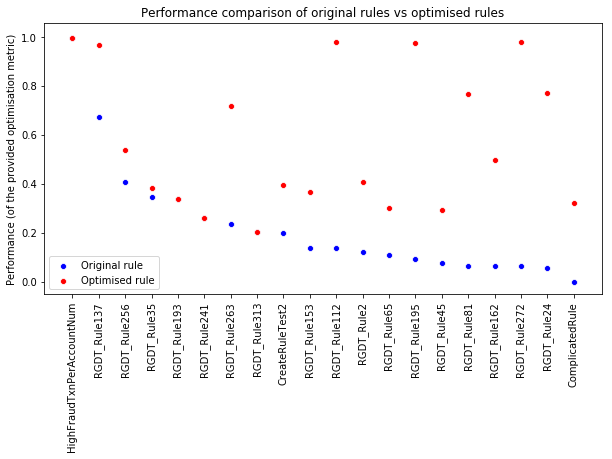

In [36]:
system_opt.plot_performance_uplift(orig_rule_performances=system_opt.orig_rule_performances,
                                   opt_rule_performances=system_opt.opt_rule_performances,
                                   figsize=(10, 5))

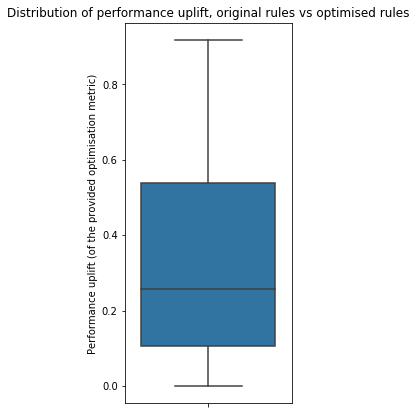

In [37]:
system_opt.plot_performance_uplift_distribution(orig_rule_performances=system_opt.orig_rule_performances,
                                                opt_rule_performances=system_opt.opt_rule_performances,
                                                figsize=(3, 7))

#### On the test set

To visualise the uplift on the test set, we first need to generate the *orig_rule_performances* and *opt_rule_performances* parameters used in the plotting methods as these aren't created as part of the optimisation process. To do this, we need to apply both the original rules and the optimised rules to the test set. **Note that before we apply the original rules, we need to remove those containing features that are missing in *X_train*:**

In [38]:
# Original rules
system_rules.filter_rules(exclude=system_opt.rule_names_missing_features)
orig_sys_rule_strings = system_rules.as_rule_strings(as_numpy=False)
orig_ra = ArgoRuleApplier(rule_strings=orig_sys_rule_strings, 
                          opt_func=f1.fit)
_ = orig_ra.apply(X=X.loc[X_test.index], y=y_test)
orig_rule_performances_test = orig_ra.rule_descriptions['OptMetric']

/Users/jlaidler/venvs/argo_test/lib/python3.7/site-packages/rules/convert_system_dicts_to_rule_dicts.py:79: UserWarning: JavaEL : Operator `java_el` is not currently supported in ARGO. Rule cannot be parsed.
  warnings.warn(f'{rule_name} : {e}')


In [39]:
# Optimised rules
opt_ra = ArgoRuleApplier(rule_strings=opt_rule_strings, 
                         opt_func=f1.fit)
_ = opt_ra.apply(X=X.loc[X_test.index], y=y_test)
opt_rule_performances_test = opt_ra.rule_descriptions['OptMetric']

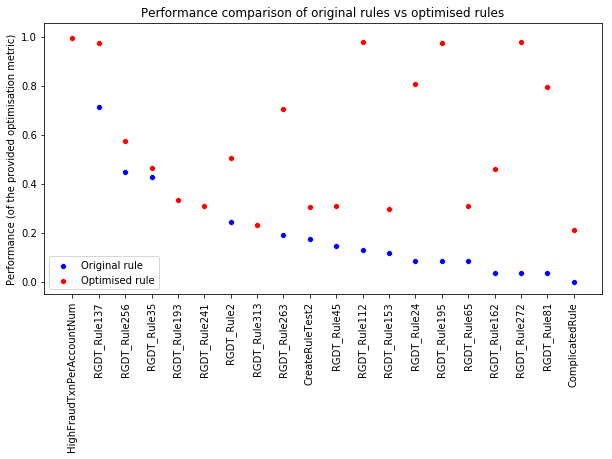

In [40]:
system_opt.plot_performance_uplift(orig_rule_performances=orig_rule_performances_test,
                                   opt_rule_performances=opt_rule_performances_test,
                                   figsize=(10, 5))

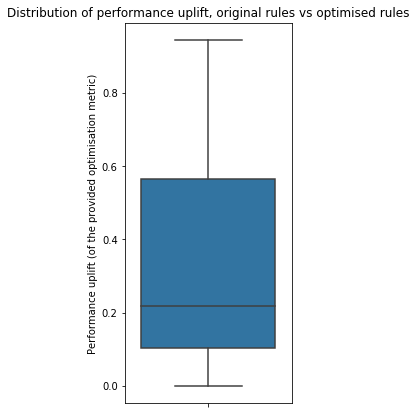

In [41]:
system_opt.plot_performance_uplift_distribution(orig_rule_performances=orig_rule_performances_test,
                                                opt_rule_performances=opt_rule_performances_test,
                                                figsize=(3, 7))

### 5. Apply the optimised rules to the dataset

Now that we have the optimised rules, we can apply them to the dataset so we can score them later:

In [42]:
X_rules_opt_sys_train = system_opt.apply(X=X.loc[X_train.index], y=y_train)

### Outputs

The *.apply()* method returns a dataframe giving the binary columns of the rules as applied to the given dataset.

A useful attribute created by running the *.apply()* method is:

* rule_descriptions: A dataframe showing the logic of the optimised rules and their performance metrics as applied to the given dataset.

### 6. Get the binary columns for the un-optimised rules

For the rules which either:

1. ARGO couldn't convert into the standard ARGO lambda expression format, or; 
2. ARGO couldn't apply to the dataset due to missing features

we can use the *SimRuleApplier* class from the *rule_application* sub-package to apply these rules to a dataset and get their performance, using the *sim_ll* column. 

**Note that we need to apply the rules to the original dataset (since the training/test sets don't have the *sim_ll* column), so we just use the X_train index to filter the original dataset to only contain those records before applying the rules:**

In [43]:
rules_cannot_be_applied = system_rules.unparsed_rules + system_opt.rule_names_missing_features

In [44]:
sra = SimRuleApplier(opt_func=f1.fit, sim_ll_column='sim_ll', rules=rules_cannot_be_applied)
X_rules_unopt_sys_train = sra.apply(X=X.loc[X_train.index], y=y_train)

### Outputs

The *.apply()* method returns a dataframe giving the binary columns of the rules as applied to the given dataset.

A useful attribute created by running the *.apply()* method is:

* rule_descriptions: A dataframe showing the logic of the rules and their performance metrics as applied to the given dataset.
* rules_not_in_sim_ll: List of rule names that were provided in the *rules* class constructor parameter but could not be found in the *sim_ll* column.

---

## Combine rules and remove those which are unnecessary <a name="CombineRules"></a>

We now have three sets of rules:

1. Newly generated rules
2. Optimised system rules
3. Unoptimised system rules

We can combine these rules, then apply correlation reduction and filtering methods to remove those which are unneccesary. To do this, we'll use the binary columns and the performance dataframes of the rules.

### Combine binary columns and performance dataframes of rules

In [45]:
X_rules_train = pd.concat([X_rules_gen_train, X_rules_opt_sys_train, X_rules_unopt_sys_train], axis=1)

In [46]:
rule_descriptions_train = pd.concat([rg_dt.rule_descriptions, system_opt.rule_descriptions, sra.rule_descriptions], axis=0)

### Standard filter

We can use the *FilterRules* class from the *rule_filters* module to filter out rules whose performance is below a desired threshold. In this example, we'll filter out rules with an F1 score below 0.05. Let's first set up our filters - **note that we use the key 'OptMetric' for the F1 score (since this is the metric that we used to generate and optimise the rules):**

In [47]:
filters = {
    'OptMetric': {
        'Operator': '>=',
        'Value': 0.05
    }
}

Now we can instantiate the *FilterRules* class and run the *fit_transform()* method to remove the rules which do not meet the filter requirements and apply the filtered rule set to the dataset:

In [48]:
fr = FilterRules(filters=filters, rule_descriptions=rule_descriptions_train)

In [49]:
X_rules_train = fr.fit_transform(X_rules=X_rules_train, y=y_train)

#### Outputs

The *.fit_transform()* method returns a dataframe containing the filtered rule binary columns. It also creates the following useful attributes:

- rules_to_keep (list): List of rules which remain after the filters have been applied.
- rule_descriptions (pd.DataFrame): The standard performance metrics dataframe associated with the filtered rules.

We can assign the *rule_descriptions* dataframe from the class to our variable, ensuring that the filtered rules are removed from the dataframe:

In [50]:
rule_descriptions_train = fr.rule_descriptions

In [51]:
X_rules_train.shape, rule_descriptions_train.shape

((8894, 286), (286, 6))

### Remove correlated rules

We can use the *FilterCorrelatedRules* class from the *rule_filters* module along with a correlation reduction class to remove correlated rules - see the *correlation_reduction_methods* module in the *correlation_reduction* sub-package for more information on these classes. 

In this example, we'll be using the *AgglomerativeClusteringFeatureReduction* class from that module. To instantiate this class, we also need to define a similarity function - see the *similarity_functions* module in the *correlation_reduction* sub-package for more information. In this example, we'll use the Jaccard similarity:

In [52]:
js = JaccardSimilarity()

In [53]:
acfr = AgglomerativeClusteringFeatureReduction(threshold=0.5,
                                               strategy='bottom_up', 
                                               similarity_function=js.fit, 
                                               columns_performance=rule_descriptions_train['OptMetric'])

Now we can instantiate the *FilterCorrelatedRules* class, and run the *fit_transform()* method to remove correlated rules and apply the filtered rule set to the dataset:

In [54]:
fcr = FilterCorrelatedRules(correlation_reduction_class=acfr, 
                            rule_descriptions=rule_descriptions_train)

In [55]:
X_rules_train = fcr.fit_transform(X_rules=X_rules_train)

#### Outputs

The *.fit_transform()* method returns a dataframe containing the binary columns of the uncorrelated rules. It also creates the following useful attributes:

- rules_to_keep (list): List of rules which remain after the correlation reduction has been applied.
- rule_descriptions (pd.DataFrame): The standard performance metrics dataframe associated with the uncorrelated rules.

We can assign the *rule_descriptions* dataframe from the class to our variable, ensuring that the correlated rules are removed from the dataframe:

In [56]:
rule_descriptions_train = fcr.rule_descriptions

In [57]:
X_rules_train.shape, rule_descriptions_train.shape

((8894, 49), (49, 6))

### Greedy filter

We can use the *GreedyFilter* class from the *rule_filters* module to sort the rules by a given metric (e.g. precision), then iterate through the rules and calculate the combined performance of the top n number of rules. Here, we'll sort the rules by precision, then calculate the F1 score of the top n combined rules:

In [58]:
gf = GreedyFilter(opt_func=f1.fit, 
                  rule_descriptions=rule_descriptions_train, 
                  sorting_col='Precision', 
                  show_plots=True)

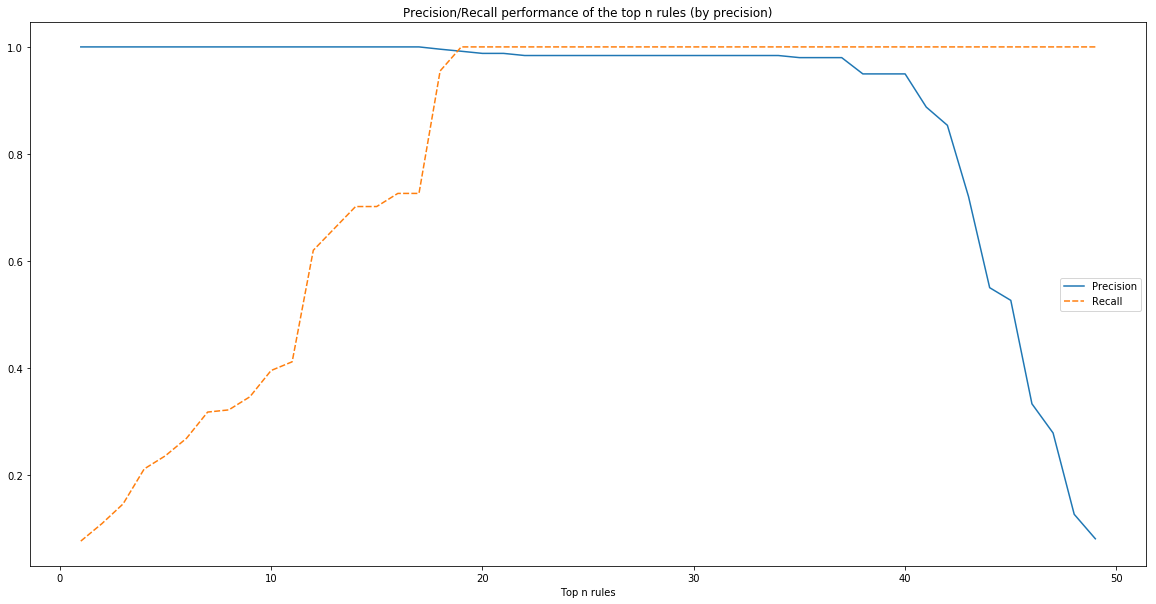

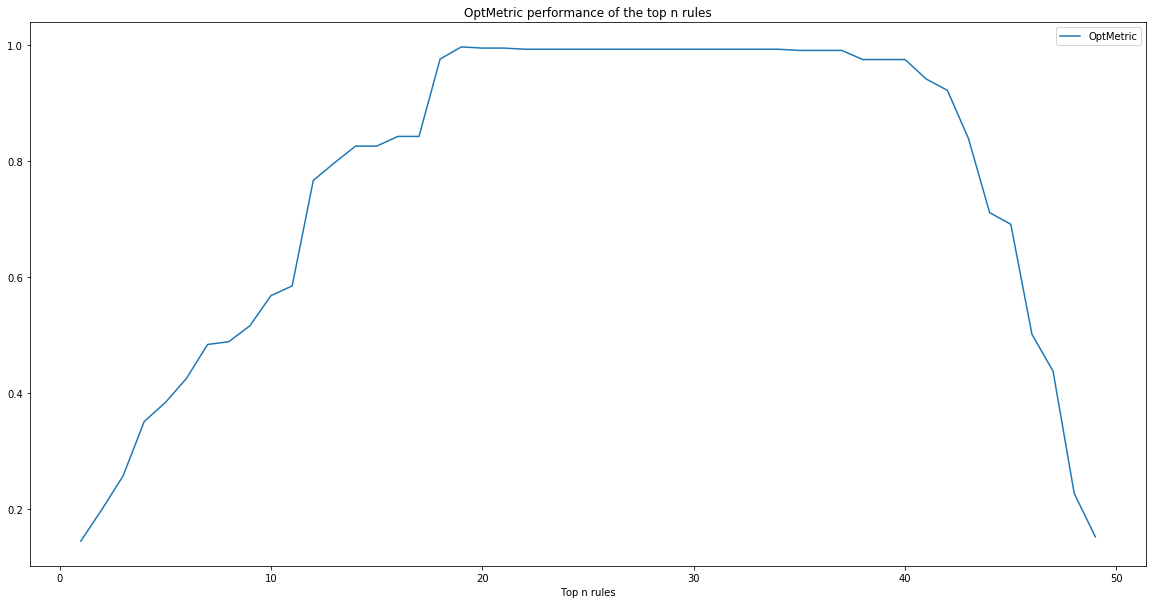

In [59]:
X_rules_train = gf.fit_transform(X_rules=X_rules_train, y=y_train)

As can be seen from the second graph, when the rules are sorted by precision, then the F1 score is calculate for the top n combined rules, the combined performance begins to plateau/drop. So the algorithm will only keep those rules that deliver the maximum combined performance (and drop the rest).

#### Outputs

The *.fit_transform()* method returns a dataframe containing the filtered rule binary columns. It also creates the following useful attributes:

- rules_to_keep (list): List of rules which remain after the filters have been applied.
- rule_descriptions (pd.DataFrame): The standard performance metrics dataframe associated with the filtered rules.

We can assign the *rule_descriptions* dataframe from the class to our variable, ensuring that the filtered rules are removed from the dataframe:

In [60]:
rule_descriptions_train = gf.rule_descriptions

In [61]:
X_rules_train.shape, rule_descriptions_train.shape

((8894, 19), (19, 6))

---

## Score rules <a name="ScoreRules"></a>

Now that we have a clean, filtered rule set, we can generate scores for each rule. 

There are two algorithms for generating rule scores:

* **LogRegScorer**: Generates rule scores from the exponentiated coefficients of a trained Logistic Regression model.
* **PerformanceScorer**: Generates rule scores from a performance function. **Choose this method if working with large (>1million records) datasets and fast runtimes are required**

There are also two rule score scaling methods:

* **ConstantScaler**: Scales rule scores using the formula (depending on the sign of the rule scores):
    * For negative scores: `x_scaled = (limit / x_min) * x`
    * For positive scores: `x_scaled = (limit / x_max) * x`
* **MinMaxScaler**: Scales rule scores using the formula:
    * x_scaled = `(x - x_min) / (x_max - x_min)`
    
To generate rule scores, we first instantiate the rule scorer and score scaler classes. In this example, we'll use the *PerformanceScorer* and *ConstantScalar* classes. Note that the performance metric we'll be using with the *PerformanceScorer* is the F1 score:

In [62]:
scorer = PerformanceScorer(performance_func=f1.fit)
scaler = ConstantScaler(limit=-100)

Now we can instantiate the *RuleScorer* class and run the *.fit()* method to generate the rule scores:

In [63]:
rs = RuleScorer(scoring_class=scorer, scaling_class=scaler)

In [64]:
X_scores = rs.fit_transform(X_rules=X_rules_train, y=y_train)

#### Outputs

The *.fit_transform()* method returns a dataframe containing the generated scores applied to the dataset (i.e. replaces the 1 in X_rules with the generated score). It also creates the following useful attribute:

- rule_scores (dict): Contains the generated score (values) for each rule (keys).

---

## Remove filtered rules from rule set <a name="RemoveFiltered"></a>

Now that we have our final rule set, we can remove the filtered rules from each of our rule set (which are saved in the *rules* attribute in our rule generator and rule optimiser classes):

In [65]:
final_rule_names = X_rules_train.columns.tolist()

In [66]:
rg_dt.rules.filter_rules(include=final_rule_names)
system_opt.rules.filter_rules(include=final_rule_names)

We also need to remove the filtered rules from the original list of unparsed rules. To do this, we'll use a simple list comprehension:

In [67]:
final_rules_cannot_be_applied = [rule_name for rule_name in rules_cannot_be_applied if rule_name in final_rule_names]

In [68]:
len(rg_dt.rules.rule_strings), len(system_opt.rules.rule_strings), len(final_rules_cannot_be_applied)

(13, 5, 1)

---

## Test final rule set and scores on test data <a name="TestFinal"></a>

Now that we have our final rule set and scores, we can apply these to the test set to ensure they perform as expected.

### Apply rules

First, we apply the rules themselves. Since we have a combination of generated, optimised and unparsed rules, we need to apply them separately.

#### Generated rules

We apply the rules by using the *rule_strings* attribute (which correponds to the generated rules stored in the standard ARGO-string format) from the rule generator class:

In [69]:
ara_gen = ArgoRuleApplier(rule_strings=rg_dt.rules.rule_strings, opt_func=f1.fit)

In [70]:
X_rules_gen_test = ara_gen.apply(X=X_test, y=y_test)

#### Optimised rules

Again, we apply the rules by using the *rule_strings* attribute (which correponds to the optimised rules stored in the standard ARGO-string format) from the rule optimiser class. However, in this case we need to use the original, raw dataset (since the optimised rules are system rules which are applied to unprocessed data):

In [71]:
ara_opt = ArgoRuleApplier(rule_strings=system_opt.rules.rule_strings, opt_func=f1.fit)

In [72]:
X_rules_opt_test = ara_opt.apply(X=X.loc[X_test.index], y=y_test)

#### Unoptimised rules 

In this case, we pass the list of final unparsed rules to the *SimRuleApplier* class, and apply it to the original, raw dataset (as this dataset contains the *sim_ll* column which is required):

In [73]:
sra = SimRuleApplier(opt_func=f1.fit, sim_ll_column='sim_ll', rules=final_rules_cannot_be_applied)

In [74]:
X_rules_unopt_sys_test = sra.apply(X=X.loc[X_test.index], y=y_test)

#### Outputs

The *.apply()* method returns a dataframe giving the binary columns of the rules as applied to the given dataset.

A useful attribute created by running the *.apply()* method is:

* rule_descriptions: A dataframe showing the logic of the generated rules and their performance metrics as applied to the given dataset.

### Apply scores

Now that we have the binary columns of our generated, optimised and unparsed rules applied to the test set, we can apply the scores. First, let's combine these binary columns into one dataframe:

In [75]:
X_test = pd.concat([X_rules_gen_test, X_rules_opt_test, X_rules_unopt_sys_test], axis=1)

Then just multiple the rule scores with these binary columns to apply the scores to the test set:

In [76]:
X_scores_test = rs.rule_scores * X_test

In [77]:
X_scores_test.head()

Rule,HighFraudTxnPerAccountNum,JavaEL,RGDT_Rule193,RGDT_Rule241,RGDT_Rule256,RGDT_Rule313,RGDT_Rule_20210304_102,RGDT_Rule_20210304_144,RGDT_Rule_20210304_189,RGDT_Rule_20210304_203,RGDT_Rule_20210304_204,RGDT_Rule_20210304_214,RGDT_Rule_20210304_228,RGDT_Rule_20210304_242,RGDT_Rule_20210304_268,RGDT_Rule_20210304_308,RGDT_Rule_20210304_312,RGDT_Rule_20210304_7,RGDT_Rule_20210304_78
eid,,,,,,,,,,,,,,,,,,,
533-3553708-0918604,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
455-3498977-3144749,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
585-6596459-3918216,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
685-6642742-5806657,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
956-2823525-9957253,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


---

## Convert generated rule conditions to system-ready <a name="ConvertGenToSys"></a>

Now that we have our final rule set and scores, we're almost ready to update the Simility environment. Before doing so, we need to convert the conditions of our generated rules to make them system-ready - this involves the following:

* Adding a null condition if the original condition included imputed null values.
* Converting conditions with OHE features into conditions that use the original feature.

To do this, we can use the *ConvertProcessedConditionsToGeneral* class from the *convert_processed_conditions_to_general* module in the *rules* sub-package. Note that we only need to apply this process to the generated rules, since those are the only rules which reference the processed data.

Before we can use this class, we need to provide the following:

* A dictionary of the value used to impute nulls for each feature in the original, unprocessed dataset.
* A dictionary of the category linked to each One Hot Encoded column.

To get these dictionaries, we can use the *ReturnMappings* class from the *convert_processed_conditions_to_general* module in the *rules* sub-package:

In [78]:
rm = ReturnMappings()

In [79]:
imputed_values_mapping = rm.return_imputed_values_mapping([num_cols, -1], [cat_cols, 'missing'], [bool_cols, 'missing'])

In [80]:
ohe_categories_mapping = rm.return_ohe_categories_mapping(pre_ohe_cols=X.columns, post_ohe_cols=X_train.columns, pre_ohe_dtypes=X.dtypes)

Now that we have our mapping dictionaries for imputed values and one hot encoded values, we can convert the logic of our generated rules to make them system-ready:

In [81]:
conv_gen_rules = ConvertProcessedConditionsToGeneral(imputed_values=imputed_values_mapping, ohe_categories=ohe_categories_mapping)

In [82]:
conv_gen_rule_strings = conv_gen_rules.convert(rule_strings=rg_dt.rules.rule_strings, X=X_train)

### Outputs

The *.convert()* method returns a dictionary containing the set of rules which account for imputed/OHE variables, defined using the standard ARGO string format (values) and their names (keys). 

**Note the following:**

- If a numeric rule condition initially had a threshold such that the imputed null values were included in the condition, the converted condition has an additional condition to check whether the feature is also null. 
    - E.g. *RGDT_Rule4* was intially *(X['num_items']<=1)*, which included the imputed value of 0. The converted rule is now *((X['num_items']<=1)|(X['num_items'].isna()))*, with an additional condition to check for nulls.
- If a categorical rule condition checks whether the value is the imputed null category, the converted condition is such that it will explicitly check for null values. 
    - E.g. *RGDT_Rule7* was initially *(X['country_missing']==True)*. The converted rule is now *(X['country'].isna())*, such that it explicitly checks for null values.
- For categorical rule conditions, the converted condition is such that it will explicitly check for the category. 
    - E.g. *RGDT_Rule3* was initially *(X['country_US']==False)*. The converted rule is now *(X['country']!='US')*, such that it explicitly checks whether the 'country' column is not equal to the 'US' category.

A useful attribute created by running the *.convert()* method is:

* rules: Class containing the rules stored in the standard ARGO string format. Methods from this class can be used to convert the rules into the standard ARGO dictionary or lambda expression representations. See the *rules* module for more information.

---

## Generate/update the system-ready configs of the rules <a name="GenUpdateSysConfigs"></a>

Now that we have our final system-ready rule set and scores, we can generate system-ready configs for the rules. How we do this depends on the type of rule:

* Generated rules: We use the *CreateNewConfigs* class from the *create_new_configs* module in the *system_config_generation* sub-package to generate new system-ready JSON configs.
* Optimised system rules: We use the *UpdateExistingConfigs* class from the *update_existing_configs* module in the *system_config_generation* sub-package to update the threshold values and scores of the existing system-ready JSON configs.
* Unoptimised (but scored) system rules: We use the *UpdateExistingConfigs* class from the *update_existing_configs* module in the *system_config_generation* sub-package to update the scores of the existing system-ready JSON configs.
* Inactivate system rules no longer required: We use the *UpdateExistingConfigs* class from the *update_existing_configs* module in the *system_config_generation* sub-package to update the status of the system rules that were originally active in the system, but have now been deemed unnecessary (either due to being correlated or poorly performing):

### Generated rules

Before we can instatiate the *CreateNewConfigs* class, we need to get the Cassandra datatypes and field names for each pipeline output field used in the rule set. To do this, we can use the *ReturnPipelineOutputDatatypes* and *ReturnCassandraPipelineOutputMapping* classes from the *cassandra_requests* module in the *simility_requests* sub-package:

In [83]:
rpodt = ReturnPipelineOutputDatatypes(url=url,
                                      app_prefix=app_prefix,
                                      user=user,
                                      base_entity=base_entity)

In [84]:
po_dtypes = rpodt.request()

In [85]:
rcpom = ReturnCassandraPipelineOutputMapping(url=url,
                                             app_prefix=app_prefix,
                                             user=user,
                                             base_entity=base_entity)

In [86]:
cassandra_field_names = rcpom.request()

Now that we have the Cassandra datatypes and field names for each pipeline output field, we can convert the conditions of the generated rules into the system-ready format:

In [87]:
final_gen_rules_sys_dicts = conv_gen_rules.rules.as_system_dicts(field_datatypes=po_dtypes, 
                                                                 cassandra_field_names=cassandra_field_names)

Once we have the rule conditions in the system-ready format, we can generate the final system-ready configurations:

In [88]:
cnc = CreateNewConfigs(conditions=final_gen_rules_sys_dicts, 
                       scores=rs.rule_scores, 
                       app_prefix=app_prefix, 
                       entity=base_entity, 
                       make_active=True)

In [89]:
final_gen_rule_configs = cnc.generate()

#### Outputs

The *.generate()* method returns a dictionary of the system-ready JSON configurations for each rule. It also saves this dictionary as the class attribute *rule_configs*. These configurations can be used with the *create_rules_in_simility* module in the *simility_requests* sub-package to generate the provided rules in a given Simility instance.

### Optimised rules

Before we can instatiate the *UpdateExistingConfigs* class, we need to get the original rule configurations from the Simility environment, so that the conditions and the scores can be updated within the configurations. To do this, we can use the *ReturnRuleConfigsFromSimility* class from the *rule_requests* module in the *simility_requests* sub-package:

In [90]:
rrcfs = ReturnRuleConfigsFromSimility(url=url,
                                      app_prefix=app_prefix,
                                      user=user,
                                      entity=base_entity,
                                      rules=system_opt.rules.rule_strings.keys()
                                     )

In [91]:
opt_rules_sys_configs = rrcfs.request()

We can use the Cassandra datatypes and field names for each pipeline output field (generated in the previous step) to convert the conditions of the optimised rules into the system-ready format:

In [92]:
final_opt_rules_sys_dicts = system_opt.rules.as_system_dicts(field_datatypes=po_dtypes, 
                                                             cassandra_field_names=cassandra_field_names)

Now that we have the original configurations and the optimised rule coniditions in the system-ready format, we can update the configurations to reflect the optimised thresholds and scores:

In [93]:
uec = UpdateExistingConfigs(rule_configs=opt_rules_sys_configs, 
                            updated_conditions=final_opt_rules_sys_dicts, 
                            updated_scores=rs.rule_scores)

In [94]:
final_opt_rule_configs = uec.update()

#### Outputs

The *.update()* method returns a dictionary of the updated system-ready JSON configurations for each rule. It also saves this dictionary as the class attribute *updated_rule_configs*. These configurations can be used with the *update_rules_in_simility* module in the *simility_requests* sub-package to update the provided rules in a given Simility instance.

### Un-optimised rules

Before we can instatiate the *UpdateExistingConfigs* class, we need to get the original rule configurations from the Simility environment, so that the scores can be updated within the configurations. To do this, we can use the *ReturnRuleConfigsFromSimility* class from the *rule_requests* module in the *simility_requests* sub-package:

In [95]:
rrcfs = ReturnRuleConfigsFromSimility(url=url,
                                      app_prefix=app_prefix,
                                      user=user,
                                      entity=base_entity,
                                      rules=final_rules_cannot_be_applied
                                     )

In [96]:
unopt_rules_sys_configs = rrcfs.request()

Now that we have the original configurations, we can update the configurations to reflect the optimised scores:

In [97]:
uec = UpdateExistingConfigs(rule_configs=unopt_rules_sys_configs, 
                            updated_scores=rs.rule_scores)

In [98]:
final_unopt_rule_configs = uec.update()

#### Outputs

The *.update()* method returns a dictionary of the updated system-ready JSON configurations for each rule. It also saves this dictionary as the class attribute *updated_rule_configs*. These configurations can be used with the *update_rules_in_simility* module in the *simility_requests* sub-package to update the provided rules in a given Simility instance.

### System rules no longer required

Before we can instatiate the *UpdateExistingConfigs* class, we need to know which system rules were in the original set that were fetched for the rule optimisation process, that are no longer in the final set of rules. To do this, we can iterate through the original rule names and check for those that aren't present in either the final optimised rule set or the final unparsed rule set:

In [99]:
sys_rules_inactivate = [rule_name for rule_name in orig_sys_conditions.keys() 
                        if rule_name not in system_opt.rules.rule_strings.keys() and rule_name not in final_rules_cannot_be_applied]

Now that we have the list of rule names we need to inactivate, we can return their original configurations:

In [100]:
rrcfs = ReturnRuleConfigsFromSimility(url=url,
                                      app_prefix=app_prefix,
                                      user=user,
                                      entity=base_entity,
                                      rules=sys_rules_inactivate
                                     )

In [101]:
sys_rules_inactivate_configs = rrcfs.request()

Finally, we can update the configurations to reflect the change in status:

In [102]:
uec = UpdateExistingConfigs(rule_configs=sys_rules_inactivate_configs, 
                            make_inactive=True)

In [103]:
final_sys_rules_inactivate_configs = uec.update()

#### Outputs

The *.update()* method returns a dictionary of the updated system-ready JSON configurations for each rule. It also saves this dictionary as the class attribute *updated_rule_configs*. These configurations can be used with the *update_rules_in_simility* module in the *simility_requests* sub-package to update the provided rules in a given Simility instance.

In [104]:
len(final_gen_rule_configs), len(final_opt_rule_configs), len(final_unopt_rule_configs), len(final_sys_rules_inactivate_configs)

(13, 5, 1, 15)

---

## Update the Simility environment with the final rule set <a name="UpdateSimility"></a>

Now that we have the system-ready configurations for our generated, optimised, un-parsed and inactivated rules, we can update the Simility environment with the final rule set. Note that we also need to inactivate the system rules that were originally active in the system, but have now been deemed uneccessary (either due to being correlated or poorly performing):

### Generated rules

In [ ]:
cris = CreateRulesInSimility(url=url,
                             app_prefix=app_prefix,
                             user=user)

In [ ]:
cris.request(rule_configs=final_gen_rule_configs)

#### Outputs

The *.request()* method does not return a value; however, once it has ran successfully, you should see the rules have been created in the Simility environment specified.

### Optimised rules

In [ ]:
uris = UpdateRulesInSimility(url=url,
                             app_prefix=app_prefix,
                             user=user)

In [ ]:
uris.request(rule_configs=final_opt_rule_configs)

### Un-optimised rules

In [ ]:
uris.request(rule_configs=final_unopt_rule_configs)

### System rules no longer required

In [ ]:
uris.request(rule_configs=final_sys_rules_inactivate_configs)

#### Outputs

The *.request()* method does not return a value; however, once it has ran successfully, you should see the rules have been updated in the Simility environment specified.

---

## The End

That's it folks - if you have any queries or suggestions please put them in the *#sim-datatools-help* Slack channel or email James directly.